In [1]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download and unzip dataset
!kaggle datasets download -d arnavr10880/concrete-crack-images-for-classification
!unzip concrete-crack-images-for-classification.zip -d content

Streaming output truncated to the last 5000 lines.
  inflating: content/Positive/15001_1.jpg  
  inflating: content/Positive/15002_1.jpg  
  inflating: content/Positive/15003_1.jpg  
  inflating: content/Positive/15004_1.jpg  
  inflating: content/Positive/15005_1.jpg  
  inflating: content/Positive/15006_1.jpg  
  inflating: content/Positive/15007_1.jpg  
  inflating: content/Positive/15008_1.jpg  
  inflating: content/Positive/15009_1.jpg  
  inflating: content/Positive/15010_1.jpg  
  inflating: content/Positive/15011_1.jpg  
  inflating: content/Positive/15012_1.jpg  
  inflating: content/Positive/15013_1.jpg  
  inflating: content/Positive/15014_1.jpg  
  inflating: content/Positive/15015_1.jpg  
  inflating: content/Positive/15016_1.jpg  
  inflating: content/Positive/15017_1.jpg  
  inflating: content/Positive/15018_1.jpg  
  inflating: content/Positive/15019_1.jpg  
  inflating: content/Positive/15020_1.jpg  
  inflating: content/Positive/15021_1.jpg  
  inflating: content/Posi

In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

#### set the data path

In [70]:
#this tells the python that the main dataset folder is named content
DATA_PATH="content"

In [71]:
def understanding_data(data_path=DATA_PATH):
    """
    this function will help us understand the data and answer simple questions like
    - how many images are there?
    - what do they look like?
    - are the classes balanced or not?
    """
    # define paths to the two dataset folders: cracked (Positive) and non-cracked (Negative)
    positive_path = Path(data_path) / "Positive"
    negative_path = Path(data_path) / "Negative"

    # count how many images (.jpg) are in each folder
    positive_images_count = len(list(positive_path.glob("*.jpg"))) if positive_path.exists() else 0
    negative_images_count = len(list(negative_path.glob("*.jpg"))) if negative_path.exists() else 0

    print("=" * 50)
    print("Dataset Overview")
    print("=" * 50)
    print(f"count of positive samples (images with cracks): {positive_images_count}")
    print(f"count of negative samples (images with no cracks): {negative_images_count}")
    print(f"total count of images: {positive_images_count + negative_images_count}")
    print(f"ratio of positive to negative images: {positive_images_count / negative_images_count:.2f}")
    print("=" * 50)

    return positive_path, negative_path


In [72]:
positive_path, negative_path = understanding_data()

Dataset Overview
count of positive samples (images with cracks): 20000
count of negative samples (images with no cracks): 20000
total count of images: 40000
ratio of positive to negative images: 1.00


#### now lets visualize the sample images to know what the model sees

In [73]:
def visualize_sample_images(data_path=DATA_PATH ,n_samples=5):

    """
    we will display samples images from both classes
    this will help us understand the image quality , how the images differ, cracked or not cracked images
    and if it needs any preprocessing
    """

    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))  # 2 rows, n_samples per row
    fig.suptitle(
        "Sample Images: Top Row= Positive(Cracked), Bottom Row =Negative(no cracks)",
        fontsize=14,
        fontweight="bold"
    )  # subtitle for the whole figure

    # find all the jpg images in both +ve and -ve folder and list the first n_samples
    positive_images = list(positive_path.glob("*.jpg"))[:n_samples]
    negative_images = list(negative_path.glob("*.jpg"))[:n_samples]

    # loop over positive images (top row)
    for i, img_path in enumerate(positive_images):
        img = plt.imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].axis("off")
        axes[0, i].set_title(f"crack image {i+1}", color="red")

    # loop over negative images (bottom row)
    for i, img_path in enumerate(negative_images):
        img = plt.imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].axis("off")
        axes[1, i].set_title(f"normal(no cracks) image {i+1}", color="red")

    plt.tight_layout()
    plt.show()


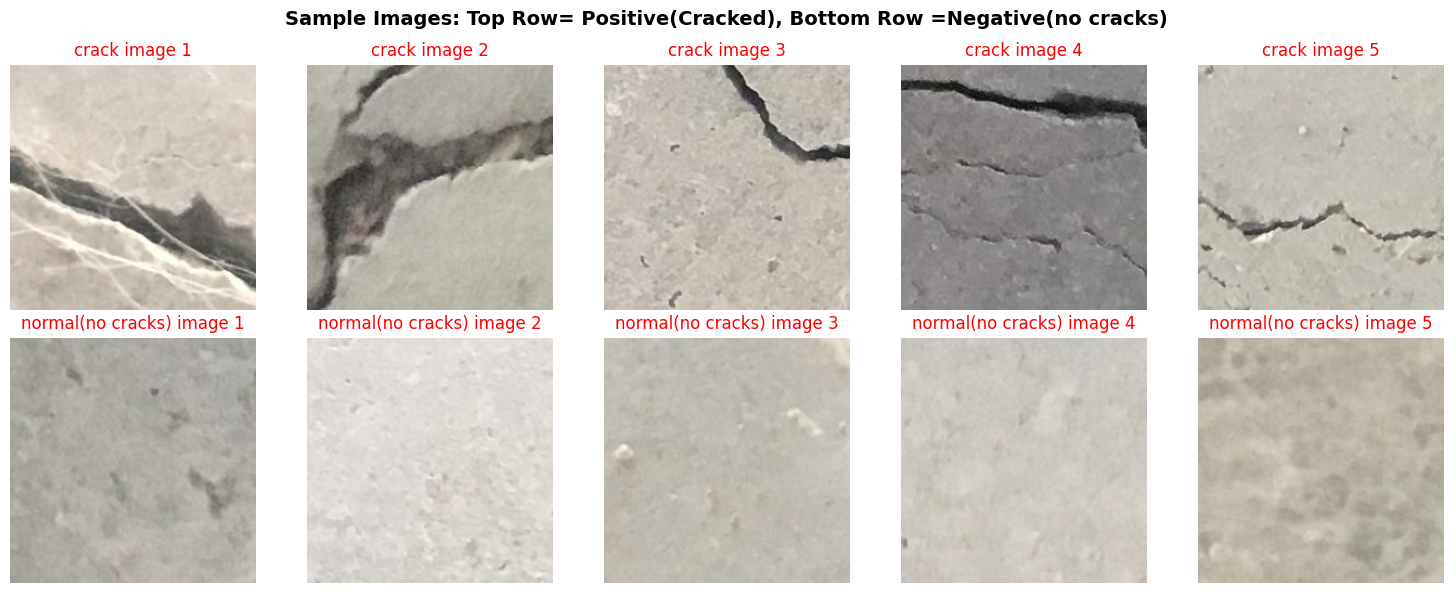

In [74]:
visualize_sample_images()

#### next, we need to load the data


In [75]:
"""
there are around 40,000 images ,loading all at onces will fry my ram ,
so we will load the images in batches of 32 images at a time
and also reduce the image size for faster processing
"""

#Configure before loading
img_size=224
batch_size=32
validation_split=0.2

# now we need to created the datasets

def create_dataset(data_path=DATA_PATH,img_size=img_size,batch_size=batch_size,val_split= validation_split):
  """
  lets understand how this will work
  -first  image_dataset_from_directory will automatically
   a)load the images from postive and negative folder thats inside the root content folder
   b) assign label (0=negative and 1 = postive)
   c) resizez the images to img_size
   d)create batches that equal to batch_size
   e) split the data into train(80%) and validation set(0.2 ie 20%)
   f) then normalize the pixels from 0-255 to 0-1
  """

  ## we will use tensorflow dataset generators to create training and validation dataset

  train_dataset= tf.keras.preprocessing.image_dataset_from_directory(
      data_path,
      validation_split=val_split,
      subset="training",
      seed=123,
      image_size=(img_size,img_size),
      batch_size=batch_size,
      label_mode="binary",
      color_mode="rgb"
  )

  validation_dataset= tf.keras.preprocessing.image_dataset_from_directory(
      data_path,
      validation_split=val_split,
      subset="validation",
      seed=123,
      image_size=(img_size,img_size), #tensorFlow to resize every image to 128×128 pixels.
      batch_size=batch_size,
      label_mode="binary",
      color_mode="rgb"
  )

  # #normalize the pixels value
  # def normalize_images(image,label):
  #   image =tf.cast(image,tf.float32) /255.0
  #   return image,label

  # train_dataset=train_dataset.map(normalize_images)
  # validation_dataset=validation_dataset.map(normalize_images)

  # for performance optimization we will prefetch, ie
  #load the next batch while training the current batch

  train_dataset= train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
  validation_dataset= validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

  return train_dataset,validation_dataset


In [76]:
train_dataset, validation_dataset= create_dataset()

Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


#### we will create a baseline model and then improve the performance

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense


In [78]:
from tensorflow.keras.models import Model
def baseline_cnn_model(img_size=img_size):
  """lets understand our baseline cnn architecture

    input(224*224)
    ↓
    convo laeyer 1 with 32 filters ->goal detect edges and lines
    ↓
    maxpool(pool_size= 2,2)
    ↓
    convo layer 2 with 64 filters -> goal detect more complex features
    ↓
    maxpool(pool_size= 2,2)
    ↓
    convo layer 3 with 64 filters->complex pattern
    ↓
    flattern to 1d
    ↓
    dense layer  with 64 neurons ,activation="relu"
    ↓
    output with sigmoid
  """

  inputs = Input(shape=(img_size,img_size,3))

  #first convo layer
  x = Conv2D(32,(3,3),activation="relu",padding="same")(inputs)
  x = MaxPooling2D(pool_size=(2,2))(x)

  #second convo layer
  x = Conv2D(64,(3,3),activation="relu",padding="same")(x)
  x = MaxPooling2D(pool_size=(2,2))(x)

  #third convo layer
  x = Conv2D(64,(3,3),activation="relu",padding="same")(x)
  x = MaxPooling2D(pool_size=(2,2))(x)

  #flatten
  x = Flatten()(x)
  #adding a dropout to prevent overfitting
  x = Dropout(0.5)(x)

  #dense layer
  x = Dense(64,activation="relu")(x)

  #output layer
  outputs = Dense(1,activation="sigmoid")(x)

  model = Model(inputs, outputs, name="baseline_cnn")

  return model

In [79]:
our_model = baseline_cnn_model()

#### lets show the model structure and summary

In [80]:
print("\n"+"="*50)
print("our model architecture")
print("="*50)
our_model.summary()


our model architecture


Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267,713 (12.47 MB)

 Trainable params: 3,267,713 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

#### now its time to compile the model

In [81]:
def compile_model(model):
  """
  we will now configure how the model should learn,
  we will configure the optimizer , loss and metrics
  """

  model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

  return model


In [82]:
our_model=compile_model(our_model)

#### after compiling, its time to train the model

In [83]:
def train_model(model, train_dataset, validation_dataset, epochs=10):
    """
    we will train the model for 10 epochs,
    each epoch the model will see all the training images once
    and checks the performance on unseen data

    we will use callbacks to apply EarlyStopping to stop training if the model stops improving
    and use ReduceLROnPlateau to reduce learning rate if stuck
    """

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5, # Stop if no improvement for 5 epochs
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.2, # Reduce learning rate by 0.2x
            patience=3
        )
    ]

    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=callbacks
    )

    return history


In [84]:
history=train_model(our_model,train_dataset,validation_dataset,epochs=10)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 53ms/step - accuracy: 0.5060 - loss: 9.2359 - val_accuracy: 0.5100 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step - accuracy: 0.5041 - loss: 0.6931 - val_accuracy: 0.5100 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.5027 - loss: 0.6931 - val_accuracy: 0.5100 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.5014 - loss: 0.6931 - val_accuracy: 0.5100 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.4938 - loss: 0.6932 - val_accuracy: 0.5100 - val_loss: 0.6931 - learning_rate: 2.0000e-04
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.5038 - loss: 0.6931 - val_accuracy: 0.4900 - val_loss: 0.6932 - learning_rate: 2.0000e-04
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 53ms/step 

In [85]:
def plot_training_history(history):
    """
    now we visualize how model improved over time
    - loss should decrease
    - accuracy should increase
    - train and validation should be close (no overfitting)
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


    ax1.plot(history.history['accuracy'], label='train accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='validation Accuracy', linewidth=2)
    ax1.set_title('model accuracy Over time', fontsize=14, fontweight='bold')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)


    ax2.plot(history.history['loss'], label='train loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='validation Loss', linewidth=2)
    ax2.set_title('model loss over time', fontsize=14, fontweight='bold')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

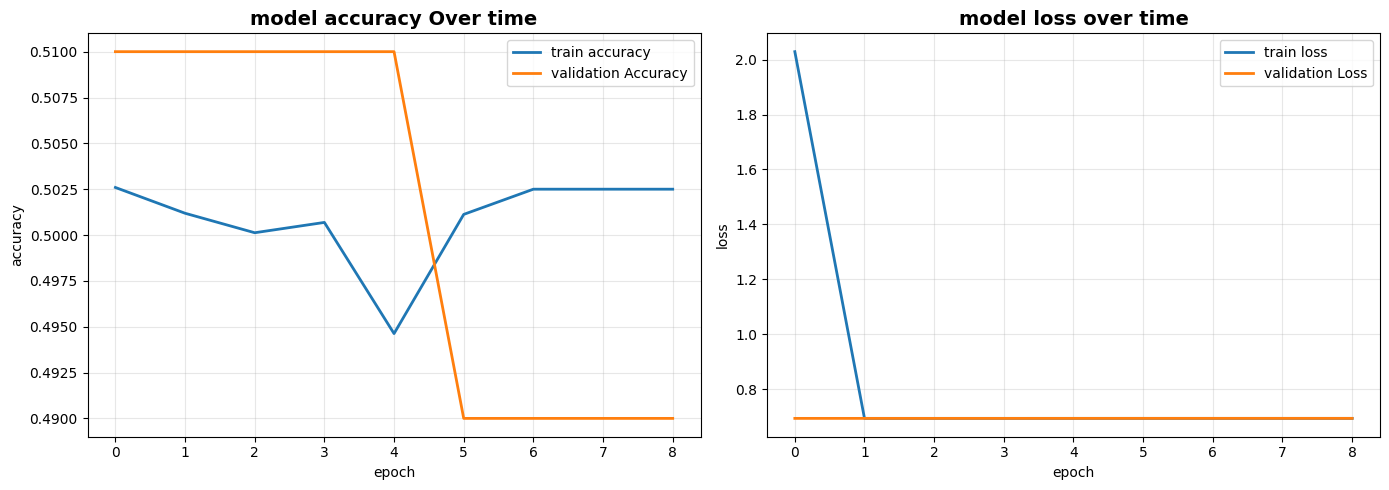

In [86]:
plot_training_history(history)

In [87]:
our_model.evaluate(validation_dataset)

250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5075 - loss: 0.6931


[0.693080484867096, 0.5099999904632568]

#### we completed our baseline model, now we can start working on working using Pretrained modele

### we will be using EfficientNet0 pretrained model

##### first the step is to augument the data, lets create a function that does that

In [88]:
def create_data_augmentation():
  """
  data aug means artificially increasing the dataset by making small random
  changes to the existing images ,to generalize better and avoid overfitting.
  we will use the exisiting images we have and apply augmentation
  i.e apply this random changes to the images:
  random rotation around 20 degree
  random zoom around 20
  random translation 15%
  random horizontal flip
  random contrast around 20%

  each augmentation simulates a real world distortion,
  we want to augument just enough to make the model robust,
  but not so much that the image loses its meaning.
  we will will use the safe range of these values.
  """

  data_augmentation= keras.Sequential([
      layers.RandomRotation(0.2),
      layers.RandomTranslation(0.15,0.15),
      layers.RandomZoom(0.2),
      layers.RandomFlip("horizontal"),
      layers.RandomContrast(0.2),
  ],name="data_augmentation")

  return data_augmentation


augmentation= create_data_augmentation()
print("data aug pipeline created")


data aug pipeline created


#### we will now visualize how  augumentation makes the training data diverse.


In [89]:
def show_augmentation_examples(image, n_examples=9):

    plt.figure(figsize=(15, 10))
    # first lets plot the original image.
    plt.subplot(3, 4, 1)
    plt.imshow(image)
    plt.title('original image', fontweight="bold", fontsize=14)
    plt.axis('off')

    # now we plot the augmented versions of the image
    for i in range(n_examples):
        # apply the augmentation pipeline to the image
        # tf.expand_dims(image, 0) adds a batch dimension because Keras layers expect input in the format (batch, height, width, channels)
        # training=True ensures that the augmentations (rotation, flip, zoom, etc.) are applied and not skipped
        augmented = augmentation(tf.expand_dims(image, 0), training=True)
        plt.subplot(3, 4, i + 2)
         # check if pixel values are in range [0, 255] or [0, 1] for proper visualization
        plt.imshow(augmented[0] / 255.0 if augmented[0].numpy().max() > 1 else augmented[0])
        plt.title(f"Augmented {i+1}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()



# from tensorflow.keras.preprocessing import image
# import tensorflow as tf

# #### this block of code is just to show how the augmentation works
# sample_image_path = "./sample.jpeg"
# img = image.load_img(sample_image_path, target_size=(224, 224))
# img_array = image.img_to_array(img)
# img_array = img_array / 255.0

# show_augmentation_examples(img_array)


#### create a function for creating the  efficient base model

In [90]:
from tensorflow.keras.applications import EfficientNetB0

#### create EfficientNetB0 base model
def create_efficientnet_basemodel(img_size=224, trainable=False):
    """
    first we load the EfficientNetB0 pretrained model.

    we are using B0 because it is the baseline EfficientNet model with ~5.3 million parameters.
    models B1-B7 are larger and will take more time to train and fine-tune.

    parameters explanation:
    - img_size: 224 x 224, the input image size expected by the model
    - trainable: False means we freeze the pretrained weights and do not update them during training.
                 we use the weights pretrained on ImageNet dataset
    - weights: 'imagenet' to use pretrained weights
    - include_top: False to remove the original classification head because we will add our own dense layer
    basically   we only get convolutional base section.

    """

    efficientnet_base = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(img_size, img_size, 3),  # 3 channels for RGB
    )

    # set whether the base model is trainable
    efficientnet_base.trainable = trainable

    # summary print
    print(f"\n{'='*60}")
    print("EfficientNetB0 base model loaded")
    print(f"{'='*60}")
    print(f"Total layers: {len(efficientnet_base.layers)}")
    print(f"Trainable: {trainable}")
    print(f"Parameters: {efficientnet_base.count_params()}")
    print(f"Input size: {img_size}x{img_size}x3")

    return efficientnet_base

#all this does is, loads the pretrained EfficientNetB0 model and returns only the convolutional base.
#we can add our own Dense layers for the specific task.

#### now we will build the complete model ,combining the convo base we get from above with our own dense layers

In [91]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
def build_model(img_size=224):
    """
    we will use the transfer learning architecture:

    Input(224x224x3)
    ↓
    Augmentation (training only)
    ↓
    EfficientNet Preprocessing (FIXED: normalize to [-1, 1])
    ↓
    EfficientNetB0 convolutional base
    ↓
    GlobalAveragePooling2D (replaces Flatten)
    ↓
    BatchNormalization
    ↓
    Dropout
    ↓
    Dense layer
    ↓
    BatchNormalization
    ↓
    Dropout
    ↓
    Dense output (Sigmoid)
    """

    base_model = create_efficientnet_basemodel(img_size, trainable=False)
    inputs=Input(shape=(img_size,img_size,3))
    x=augmentation(inputs)
    print(f"Shape after augmentation: {x.shape}")
    x=keras.applications.efficientnet.preprocess_input(x) #use efficientNet's preprocessing function
    x=base_model(x,training=False)

    x=layers.GlobalAveragePooling2D()(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.5)(x)
    x=layers.Dense(256,activation="relu",kernel_regularizer=l2(0.001))(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.3)(x)

    outputs= layers.Dense(1,activation="sigmoid")(x)

    model=Model(inputs,outputs,name="final_model")

    return model

#create the final model
complete_model = build_model()

print("\n" + "="*60)
print("efficientnet transfer learning model")
print("="*60)
complete_model.summary()




EfficientNetB0 base model loaded
Total layers: 238
Trainable: False
Parameters: 4049571
Input size: 224x224x3
Shape after augmentation: (None, 224, 224, 3)

efficientnet transfer learning model


Model: "final_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,908 (16.72 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

#### we will now create a function that takes the model and compiles it


In [92]:
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

def compile_model(model):
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            keras.metrics.AUC(name="auc")
        ]
    )


    print("\n model compiled with optimized settings")
    print("\nmetrics explained:")
    print("  - accuracy: overall correctness")
    print("  - precision: correct crack predictions")
    print("  - recall: detected real cracks")
    print("  - auc: overall model quality (higher is better)")

    return model

# compile the model by calling the func
complete_model = compile_model(complete_model)



 model compiled with optimized settings

metrics explained:
  - accuracy: overall correctness
  - precision: correct crack predictions
  - recall: detected real cracks
  - auc: overall model quality (higher is better)


#### after compilation, its time to train the model

In [93]:
#### we will create the function to train the model

In [94]:
def train_eff_model(model,train_dataset,validation_dataset,epochs=20):
  """
  we will keep the efficientNet weights frozen(use pretrained knowledge)
  and train only the classificiation head (the ann section)to learn the crack patterns
  and we will use callbacks to make the training smarter and more stable

  in callbacks,
  we  will use early stopping-> ie stop if val_auc doesnt improve for 5 epochs
  we will use ReduceLROnPlateau →ie halve learning rate if stuck for 3 epochs
 and ModelCheckpoint → ie save the best model automatically
  """

  callbacks=[
      # stop early if no improvement
      keras.callbacks.EarlyStopping(
          monitor="val_auc",
          patience=5,
          restore_best_weights=True,
          mode="max", #indicates we want to maximize the monitored metric (val_auc). If using accuracy, also "max". For loss, use "min".
          verbose=1
      ),
      #reduce the learning rate when stuck
      keras.callbacks.ReduceLROnPlateau(
          monitor="val_loss",
          factor=0.5,
          patience=3,
          min_lr=1e-7, #lr cant go low than this
          verbose=1
      ),
      #save the best model
    keras.callbacks.ModelCheckpoint(
    'models/best_model.keras',  # New Keras format
    monitor="val_auc",
    save_best_only=True,
    mode='max',
    verbose=1
)
  ]

  print("\n" + "="*60)
  print("training classification head(the ann part)")
  print("\n" + "="*60)
  print("base model frozen keeping imagenet knowledge")
  print("training classfication layers only")
  print("="*60 + "\n")

  history= model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, verbose=1,callbacks=callbacks)

  print("\n" + "="*60)
  print("✓ PHASE 1 COMPLETE")
  print("="*60)

  return history


In [95]:
history=train_eff_model(complete_model,train_dataset,validation_dataset,epochs=20)


training classification head(the ann part)

base model frozen keeping imagenet knowledge
training classfication layers only

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9641 - auc: 0.9905 - loss: 0.4878 - precision: 0.9733 - recall: 0.9544
Epoch 1: val_auc improved from -inf to 0.99972, saving model to models/best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 120s 108ms/step - accuracy: 0.9641 - auc: 0.9905 - loss: 0.4877 - precision: 0.9733 - recall: 0.9545 - val_accuracy: 0.9977 - val_auc: 0.9997 - val_loss: 0.3169 - val_precision: 0.9987 - val_recall: 0.9967 - learning_rate: 1.0000e-04
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9932 - auc: 0.9992 - loss: 0.3076 - precision: 0.9945 - recall: 0.9921
Epoch 2: val_auc improved from 0.99972 to 0.99986, saving model to models/best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 106s 105ms/step - accuracy: 0.9932 - auc: 0.9992 - loss: 0.3076 - precision: 0.9945 - recall: 0.9921 - val_accuracy: 0.

#### this part of the code was generated using gpt, i got too bored to write it myself  lol

🔍 Loading best model from: models/best_model.keras
✓ Model loaded successfully!
Loading best model...
✓ Model loaded successfully!

EVALUATING MODEL ON VALIDATION SET
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.9986 - auc: 0.9998 - loss: 0.2313 - precision: 0.9980 - recall: 0.9992

VALIDATION RESULTS:
Loss: 0.2311
Accuracy: 0.9986 (99.86%)
Precision: 0.9977
Recall: 0.9995
AUC: 0.9999

GENERATING PREDICTIONS...
✓ Generated 8000 predictions


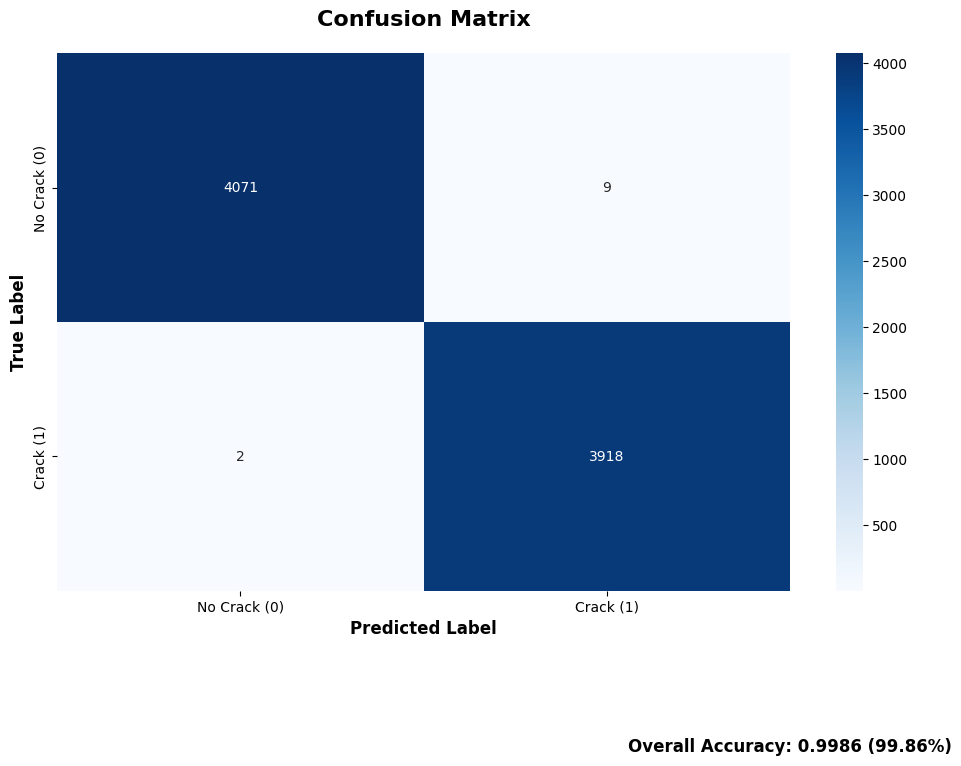


CONFUSION MATRIX BREAKDOWN:
True Negatives (Correct No Crack): 4071
False Positives (Wrongly predicted Crack): 9
False Negatives (Missed Cracks): 2
True Positives (Correct Crack detection): 3918

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Crack     0.9995    0.9978    0.9987      4080
       Crack     0.9977    0.9995    0.9986      3920

    accuracy                         0.9986      8000
   macro avg     0.9986    0.9986    0.9986      8000
weighted avg     0.9986    0.9986    0.9986      8000


Metrics Explanation:
  - Precision: Of all crack predictions, how many were correct?
  - Recall: Of all actual cracks, how many did we detect?
  - F1-Score: Harmonic mean of precision and recall
  - Support: Number of samples in each class


/tmp/ipython-input-3031607087.py:202: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data_to_plot, labels=['No Crack (True)', 'Crack (True)'],


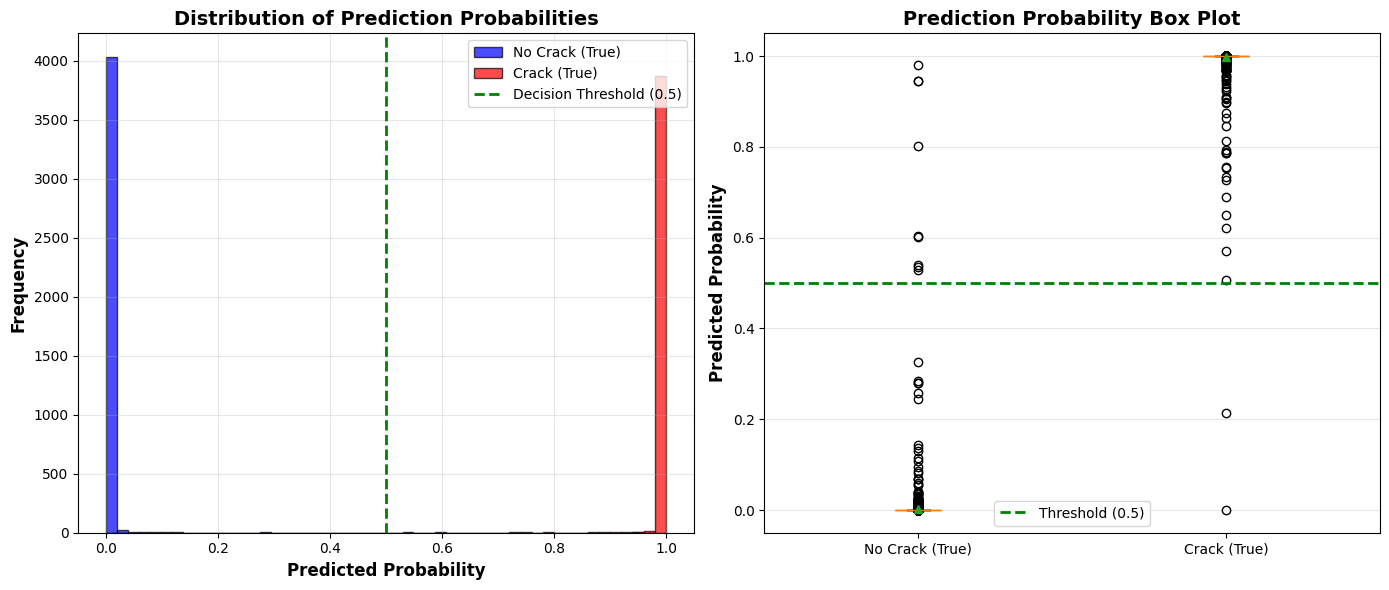


PREDICTION CONFIDENCE STATISTICS
No Crack samples - Mean confidence: 0.0028
Crack samples - Mean confidence: 0.9978


/tmp/ipython-input-3031607087.py:254: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[i].numpy())


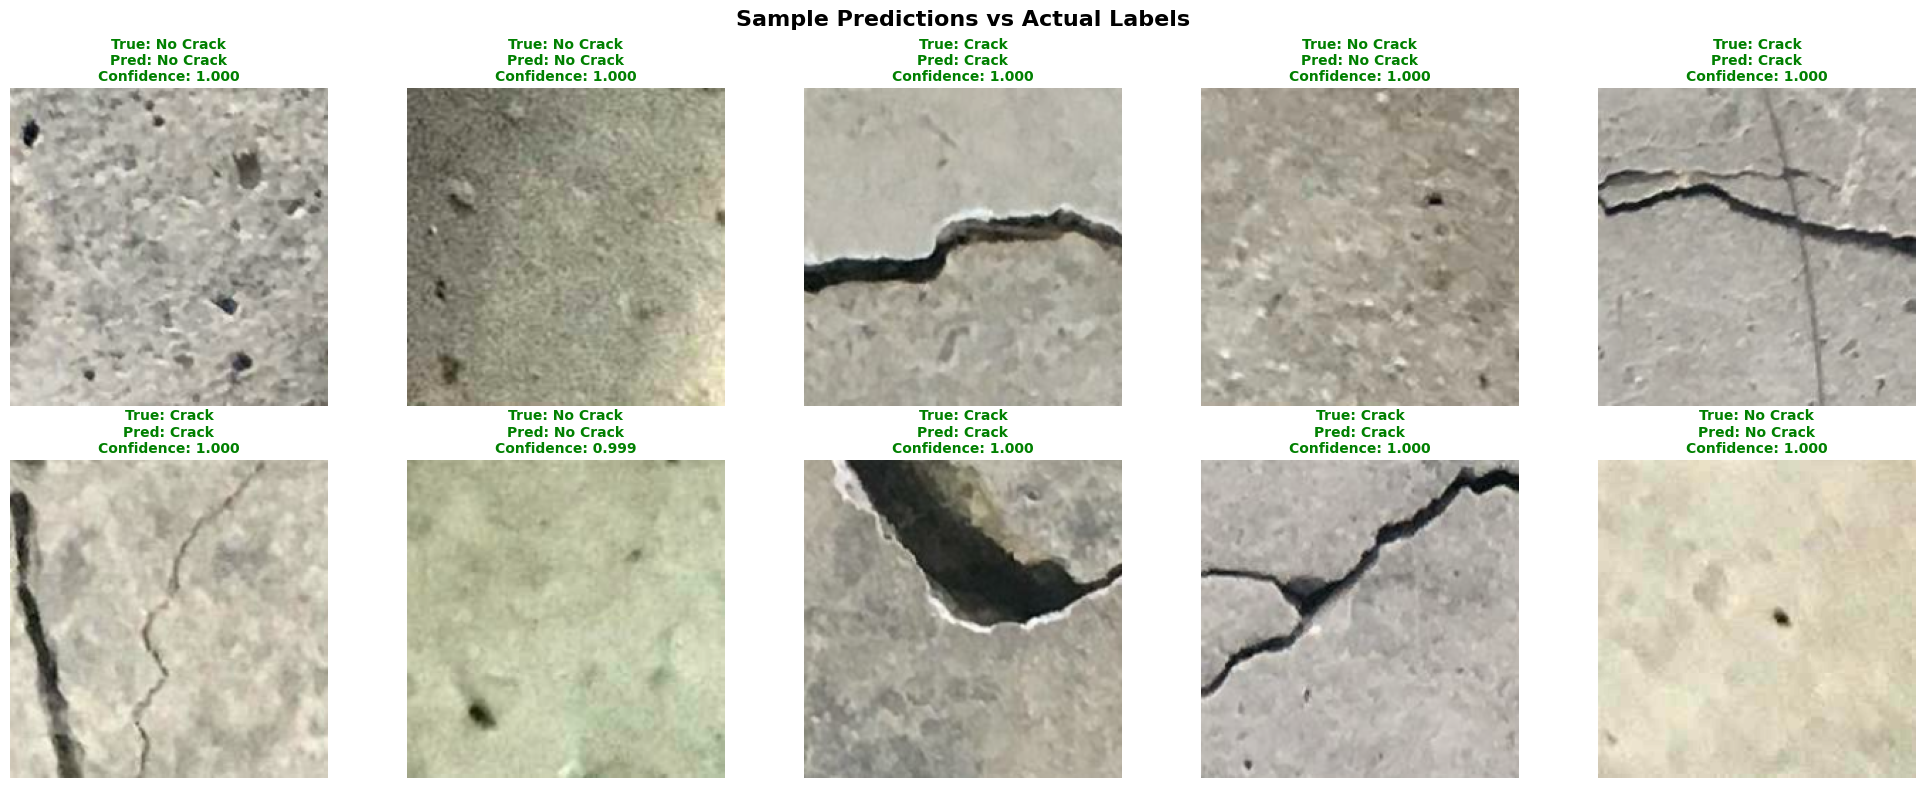


ANALYZING MISCLASSIFIED IMAGES
Found 10 misclassified images


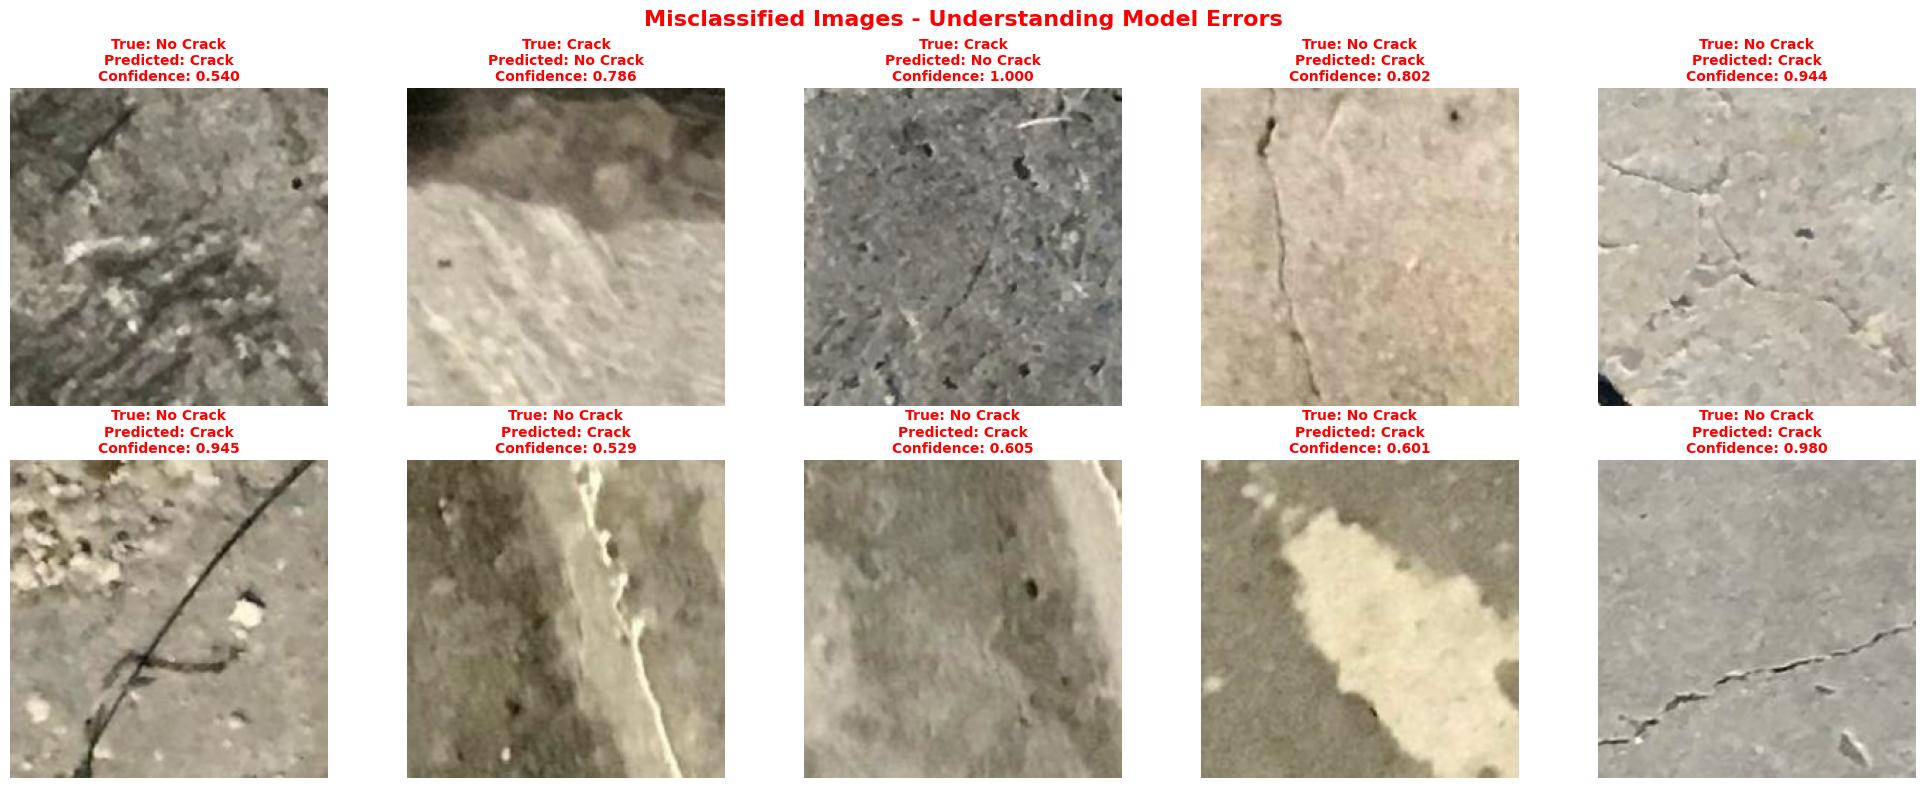


✓ Evaluation summary saved to 'models/evaluation_summary.txt'


In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)
import os
import random

def load_best_model(model_path):
    print("=" * 60)
    print(f"🔍 Loading best model from: {model_path}")
    print("=" * 60)

    model = load_model(model_path)
    print("✓ Model loaded successfully!")
    return model

best_model = load_best_model('models/best_model.keras')

#load the saved model
def load_best_model(model_path='models/best_model.keras'):
    """
    Load the best model saved during training
    """
    print("=" * 60)
    print("Loading best model...")
    print("=" * 60)

    model = load_model(model_path)
    print(" Model loaded successfully!")

    return model

best_model = load_best_model('models/best_model.keras')

#evaluate the model on the validation data
def evaluate_model(model, validation_dataset):
    """
    Evaluate the model on validation data and print metrics
    """
    print("\n" + "=" * 60)
    print("EVALUATING MODEL ON VALIDATION SET")
    print("=" * 60)

    results = model.evaluate(validation_dataset, verbose=1)

    print("\n" + "=" * 60)
    print("VALIDATION RESULTS:")
    print("=" * 60)
    print(f"Loss: {results[0]:.4f}")
    print(f"Accuracy: {results[1]:.4f} ({results[1]*100:.2f}%)")
    print(f"Precision: {results[2]:.4f}")
    print(f"Recall: {results[3]:.4f}")
    print(f"AUC: {results[4]:.4f}")
    print("=" * 60)

    return results

# Evaluate the model
evaluation_results = evaluate_model(best_model, validation_dataset)


# ============================================================
# 3. GET PREDICTIONS AND TRUE LABELS
# ============================================================

def get_predictions_and_labels(model, dataset):
    """
    Get predictions and true labels from the dataset
    """
    print("\n" + "=" * 60)
    print("GENERATING PREDICTIONS...")
    print("=" * 60)

    y_true = []
    y_pred_probs = []

    # Get predictions for all batches
    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        y_pred_probs.extend(predictions.flatten())
        y_true.extend(labels.numpy().flatten())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

    print(f"✓ Generated {len(y_true)} predictions")

    return y_true, y_pred, y_pred_probs

# Get predictions
y_true, y_pred, y_pred_probs = get_predictions_and_labels(best_model, validation_dataset)


# ============================================================
# 4. CONFUSION MATRIX
# ============================================================

def plot_confusion_matrix(y_true, y_pred):
    """
    Plot confusion matrix to visualize model performance
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['No Crack (0)', 'Crack (1)'],
                yticklabels=['No Crack (0)', 'Crack (1)'])

    plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

    # Add text annotations for better understanding
    total = cm.sum()
    accuracy = (cm[0,0] + cm[1,1]) / total

    plt.text(1, -0.3, f'Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)',
             ha='center', fontsize=12, fontweight='bold',
             transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

    # Print confusion matrix statistics
    print("\n" + "=" * 60)
    print("CONFUSION MATRIX BREAKDOWN:")
    print("=" * 60)
    print(f"True Negatives (Correct No Crack): {cm[0,0]}")
    print(f"False Positives (Wrongly predicted Crack): {cm[0,1]}")
    print(f"False Negatives (Missed Cracks): {cm[1,0]}")
    print(f"True Positives (Correct Crack detection): {cm[1,1]}")
    print("=" * 60)

    return cm

# Plot confusion matrix
cm = plot_confusion_matrix(y_true, y_pred)


# ============================================================
# 5. CLASSIFICATION REPORT
# ============================================================

def print_classification_report(y_true, y_pred):
    """
    Print detailed classification report
    """
    print("\n" + "=" * 60)
    print("DETAILED CLASSIFICATION REPORT")
    print("=" * 60)

    report = classification_report(y_true, y_pred,
                                    target_names=['No Crack', 'Crack'],
                                    digits=4)
    print(report)

    print("\nMetrics Explanation:")
    print("  - Precision: Of all crack predictions, how many were correct?")
    print("  - Recall: Of all actual cracks, how many did we detect?")
    print("  - F1-Score: Harmonic mean of precision and recall")
    print("  - Support: Number of samples in each class")
    print("=" * 60)

# Print classification report
print_classification_report(y_true, y_pred)


# ============================================================
# 6. PREDICTION DISTRIBUTION
# ============================================================

def plot_prediction_distribution(y_true, y_pred_probs):
    """
    Visualize the distribution of prediction probabilities
    """
    plt.figure(figsize=(14, 6))

    # Separate probabilities by true class
    no_crack_probs = y_pred_probs[y_true == 0]
    crack_probs = y_pred_probs[y_true == 1]

    # Plot 1: Histogram
    plt.subplot(1, 2, 1)
    plt.hist(no_crack_probs, bins=50, alpha=0.7, label='No Crack (True)', color='blue', edgecolor='black')
    plt.hist(crack_probs, bins=50, alpha=0.7, label='Crack (True)', color='red', edgecolor='black')
    plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
    plt.xlabel('Predicted Probability', fontsize=12, fontweight='bold')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold')
    plt.title('Distribution of Prediction Probabilities', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Box plot
    plt.subplot(1, 2, 2)
    data_to_plot = [no_crack_probs, crack_probs]
    box = plt.boxplot(data_to_plot, labels=['No Crack (True)', 'Crack (True)'],
                      patch_artist=True, showmeans=True)

    # Color the boxes
    colors = ['blue', 'red']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    plt.axhline(y=0.5, color='green', linestyle='--', linewidth=2, label='Threshold (0.5)')
    plt.ylabel('Predicted Probability', fontsize=12, fontweight='bold')
    plt.title('Prediction Probability Box Plot', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print("PREDICTION CONFIDENCE STATISTICS")
    print("=" * 60)
    print(f"No Crack samples - Mean confidence: {no_crack_probs.mean():.4f}")
    print(f"Crack samples - Mean confidence: {crack_probs.mean():.4f}")
    print("=" * 60)

# Plot prediction distribution
plot_prediction_distribution(y_true, y_pred_probs)


# ============================================================
# 7. VISUALIZE SAMPLE PREDICTIONS
# ============================================================

def visualize_predictions(model, dataset, n_samples=10):
    """
    Visualize sample predictions with their actual labels
    """
    # Get one batch of images and labels
    for images, labels in dataset.take(1):
        predictions = model.predict(images, verbose=0)

        # Select random samples
        indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)

        # Create subplots
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        fig.suptitle('Sample Predictions vs Actual Labels', fontsize=16, fontweight='bold')

        for idx, ax in enumerate(axes.flat):
            if idx < len(indices):
                i = indices[idx]
                img = images[i].numpy()
                true_label = int(labels[i].numpy())
                pred_prob = predictions[i][0]
                pred_label = int(pred_prob > 0.5)

                # Denormalize image for display (EfficientNet preprocessing uses [-1, 1])
                img_display = (img - img.min()) / (img.max() - img.min())

                ax.imshow(img_display)
                ax.axis('off')

                # Color code: green for correct, red for incorrect
                color = 'green' if pred_label == true_label else 'red'

                title = f"True: {'Crack' if true_label else 'No Crack'}\n"
                title += f"Pred: {'Crack' if pred_label else 'No Crack'}\n"
                title += f"Confidence: {pred_prob:.3f}" if pred_label else f"Confidence: {1-pred_prob:.3f}"

                ax.set_title(title, color=color, fontweight='bold', fontsize=10)
            else:
                ax.axis('off')

        plt.tight_layout()
        plt.show()
        break

# Visualize sample predictions
visualize_predictions(best_model, validation_dataset, n_samples=10)


# ============================================================
# 8. ERROR ANALYSIS - FIND MISCLASSIFIED IMAGES
# ============================================================

def analyze_errors(model, dataset, max_errors=10):
    """
    Find and visualize misclassified images to understand model failures
    """
    print("\n" + "=" * 60)
    print("ANALYZING MISCLASSIFIED IMAGES")
    print("=" * 60)

    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    misclassified_probs = []

    # Collect misclassified samples
    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        pred_labels = (predictions > 0.5).astype(int).flatten()
        true_labels = labels.numpy().flatten()

        # Find misclassified indices in this batch
        misclassified_idx = np.where(pred_labels != true_labels)[0]

        for idx in misclassified_idx:
            if len(misclassified_images) < max_errors:
                misclassified_images.append(images[idx].numpy())
                misclassified_labels.append(true_labels[idx])
                misclassified_preds.append(pred_labels[idx])
                misclassified_probs.append(predictions[idx][0])

        if len(misclassified_images) >= max_errors:
            break

    if len(misclassified_images) == 0:
        print("✓ NO MISCLASSIFIED IMAGES FOUND! Perfect predictions!")
        print("=" * 60)
        return

    print(f"Found {len(misclassified_images)} misclassified images")
    print("=" * 60)

    # Visualize misclassified images
    n_rows = (len(misclassified_images) + 4) // 5
    fig, axes = plt.subplots(n_rows, 5, figsize=(20, 4*n_rows))
    fig.suptitle('Misclassified Images - Understanding Model Errors',
                 fontsize=16, fontweight='bold', color='red')

    if n_rows == 1:
        axes = axes.reshape(1, -1)

    for idx, ax in enumerate(axes.flat):
        if idx < len(misclassified_images):
            img = misclassified_images[idx]
            true_label = misclassified_labels[idx]
            pred_label = misclassified_preds[idx]
            pred_prob = misclassified_probs[idx]

            # Denormalize for display
            img_display = (img - img.min()) / (img.max() - img.min())

            ax.imshow(img_display)
            ax.axis('off')

            title = f"True: {'Crack' if true_label else 'No Crack'}\n"
            title += f"Predicted: {'Crack' if pred_label else 'No Crack'}\n"
            title += f"Confidence: {pred_prob:.3f}" if pred_label else f"Confidence: {1-pred_prob:.3f}"

            ax.set_title(title, color='red', fontweight='bold', fontsize=10)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Analyze errors
analyze_errors(best_model, validation_dataset, max_errors=10)


# ============================================================
# 9. SAVE EVALUATION SUMMARY
# ============================================================

def save_evaluation_summary(results, cm, y_true, y_pred):
    """
    Save evaluation metrics to a text file
    """
    with open('models/evaluation_summary.txt', 'w') as f:
        f.write("=" * 60 + "\n")
        f.write("CONCRETE CRACK DETECTION - EVALUATION SUMMARY\n")
        f.write("=" * 60 + "\n\n")

        f.write("MODEL PERFORMANCE METRICS:\n")
        f.write("-" * 60 + "\n")
        f.write(f"Loss: {results[0]:.4f}\n")
        f.write(f"Accuracy: {results[1]:.4f} ({results[1]*100:.2f}%)\n")
        f.write(f"Precision: {results[2]:.4f}\n")
        f.write(f"Recall: {results[3]:.4f}\n")
        f.write(f"AUC: {results[4]:.4f}\n\n")

        f.write("CONFUSION MATRIX:\n")
        f.write("-" * 60 + "\n")
        f.write(f"True Negatives: {cm[0,0]}\n")
        f.write(f"False Positives: {cm[0,1]}\n")
        f.write(f"False Negatives: {cm[1,0]}\n")
        f.write(f"True Positives: {cm[1,1]}\n\n")

        f.write("CLASSIFICATION REPORT:\n")
        f.write("-" * 60 + "\n")
        f.write(classification_report(y_true, y_pred,
                                      target_names=['No Crack', 'Crack'],
                                      digits=4))

        f.write("\n" + "=" * 60 + "\n")

    print("\n✓ Evaluation summary saved to 'models/evaluation_summary.txt'")

# Save evaluation summary
save_evaluation_summary(evaluation_results, cm, y_true, y_pred)


In [98]:
from google.colab import files

# The path where ModelCheckpoint saved your best model
model_path = 'models/best_model.keras'

# Download to local
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# # ============================================================
# # STEP 1: Create project folder and copy important files
# # ============================================================

# !mkdir -p safequak_project_v1.0/models

# # Copy your model and evaluation summary
# !cp -r models/best_model.keras safequak_project_v1.0/models/
# !cp -r models/evaluation_summary.txt safequak_project_v1.0/models/

# # Copy your final notebook
# !cp -r code.ipynb safequak_project_v1.0/

# # ============================================================
# # STEP 2: Zip the entire project folder
# # ============================================================

# !zip -r safequak_project_v1.0_new.zip safequak_project_v1.0

# # ============================================================
# # STEP 3: Download the zip file (for Google Colab)
# # ============================================================

# from google.colab import files
# files.download('safequak_project_v1.0_new.zip')
